# Unveiling Drift Anomalies: A Intelligent Approach to Visualizing Data using Scatter and Autoencoders

* **Authors**: Luca Podo, Alessandro Di Patria
* **Emails**: podo@di.uniroma1.it, dipatria.1844538@studenti.uniroma1.it
* **Institution**: Sapienza University of Rome

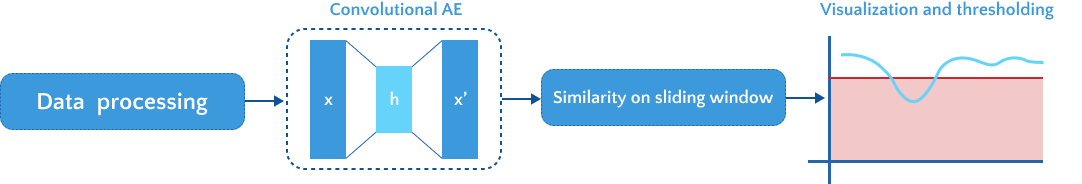

## Table of Contents

1. [Introduction](#introduction)
2. [Background](#background)
   1. [Drift anomaly](#drift)
   2. [What is an autoencder?](#autoencoder)
3. [Methodology](#methodology)
   1. [Description of the input dataset](#read)
   2. [Data transformation](#tranformation)
   3. [Autoencoder architecture](#architecture)
   4. [Profile similarity comparison](#comparison)
4. [Conclusion and result](#conclusion_and_results)
5. [References](#references)

## Introduction  <a name="introduction"></a>
Discovering and understanding shift anomalies in time series data can be challenging due to their persistent deviations from the usual trend [\[3\]](#references). Unlike isolated point anomalies, shift anomalies disrupt the overall pattern, making their identification crucial across different domains. In this blog post, we present a novel visual approach that combines a simple deep learning model, specifically an autoencoder, with scatter plots to enhance the visualization and detection of shift anomalies.


Here, we leverage the power of deep learning models to capture complex patterns and representations in data. By integrating deep learning algorithms, visual analytics techniques, and domain expert decision processes, we provide a comprehensive solution [\[2\]](#references). The compact architecture of the autoencoder effectively learns the latent features of the time series, enabling a better understanding and identification of shift anomalies [\[1\]](#references). Moreover, the autoencoder's ability to reconstruct the input data brings the discrepancies caused by these anomalies into focus, making them visually distinguishable in scatter plots.

We propose to take advantage of human observers' inherent visual perception capabilities, enhancing the interpretability of shift anomaly detection by emphasizing anomalies and reducing the emphasis on normality. Our approach facilitates more accurate and context-aware decision-making by empowering domain experts to visualize and analyze anomalies visually. **It serves as a supportive visual tool for exploratory data analysis rather than an automated anomaly detection model.**

## Background <a name="background"></a>

### Drift anomaly <a name="drift"></a>

Drift anomalies in time series data refer to significant changes or shifts in the underlying pattern or behavior of a sequence of data points over time. These anomalies can occur gradually or abruptly, posing challenges for accurate prediction, analysis, and decision-making processes.

**Shift Anomalies Across Domains**:
Drift anomalies can manifest in various domains, including finance, sensor data analysis, network monitoring, and industrial processes. They can arise from unexpected events, system failures, human errors, or external factors that introduce abrupt changes to the underlying dynamics of the time series data.

**Real-World Shift Anomaly: The Heatwave Scenario**:
To better comprehend drift anomalies, let's consider an example regarding measurement of temperature values in a region known for its stable climate and consistent seasonal temperature variations (e.g., the Amazon rainforest). Suddenly, a high-pressure system settles over the area, causing a heatwave. As a result, the region experiences an unexpected and drastic increase in temperature for an extended period, surpassing historical records for that particular season. *This shift anomaly leads to extreme heat, triggering challenges such as heatwaves, increased energy demands, and potential risks to human health and the environment.* This example highlights the broader implications of drift anomalies beyond financial contexts.

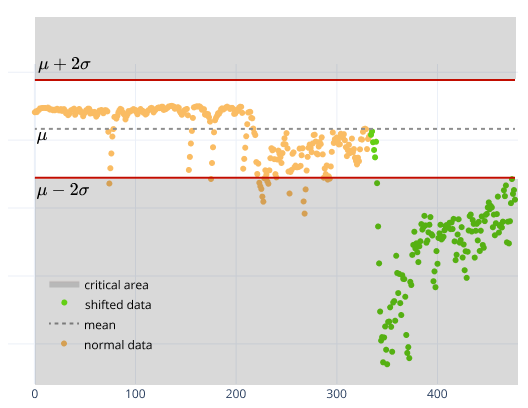

The image displays a shift anomaly in a sample temparature time series, represented by the green data point that starts to deviate from the normal behavior.

### What is an autoencoder? <a name="methodology"></a>

The autoencoder is a neural network architecture consisting of two main components: the encoder and the decoder. Unlike traditional supervised learning models, the autoencoder operates unsupervised, discovering patterns in data without explicit labeling.

The encoder compresses input data into a lower-dimensional latent space, capturing essential features. Conversely, the decoder takes the compressed information and reconstructs it to produce an output resembling the original input.

The bottleneck layer acts as the interface between the encoder and decoder, holding the dense representation of the compressed data. It contains critical information with lower dimensionality.

In the autoencoder structure, the encoder function is denoted as $g_{\phi}$ (with ${\phi}$ representing parameters) and the decoder function as $f_{\theta}$ (with ${\theta}$ representing parameters). The latent space is represented as $z=g_{\phi}(x)$, where $x$ is the input data. The reconstructed information is denoted as $x'=f_{\theta}(g_{\phi}(x))$. During training, the functions' parameters are adjusted to minimize the loss function, aiming to generate an output closely resembling the input data.

The autoencoder learns to compress and reconstruct input data by iteratively adjusting parameters, capturing underlying patterns. The goal is to obtain an output that closely resembles the original input, effectively learning a compact representation in the latent space.


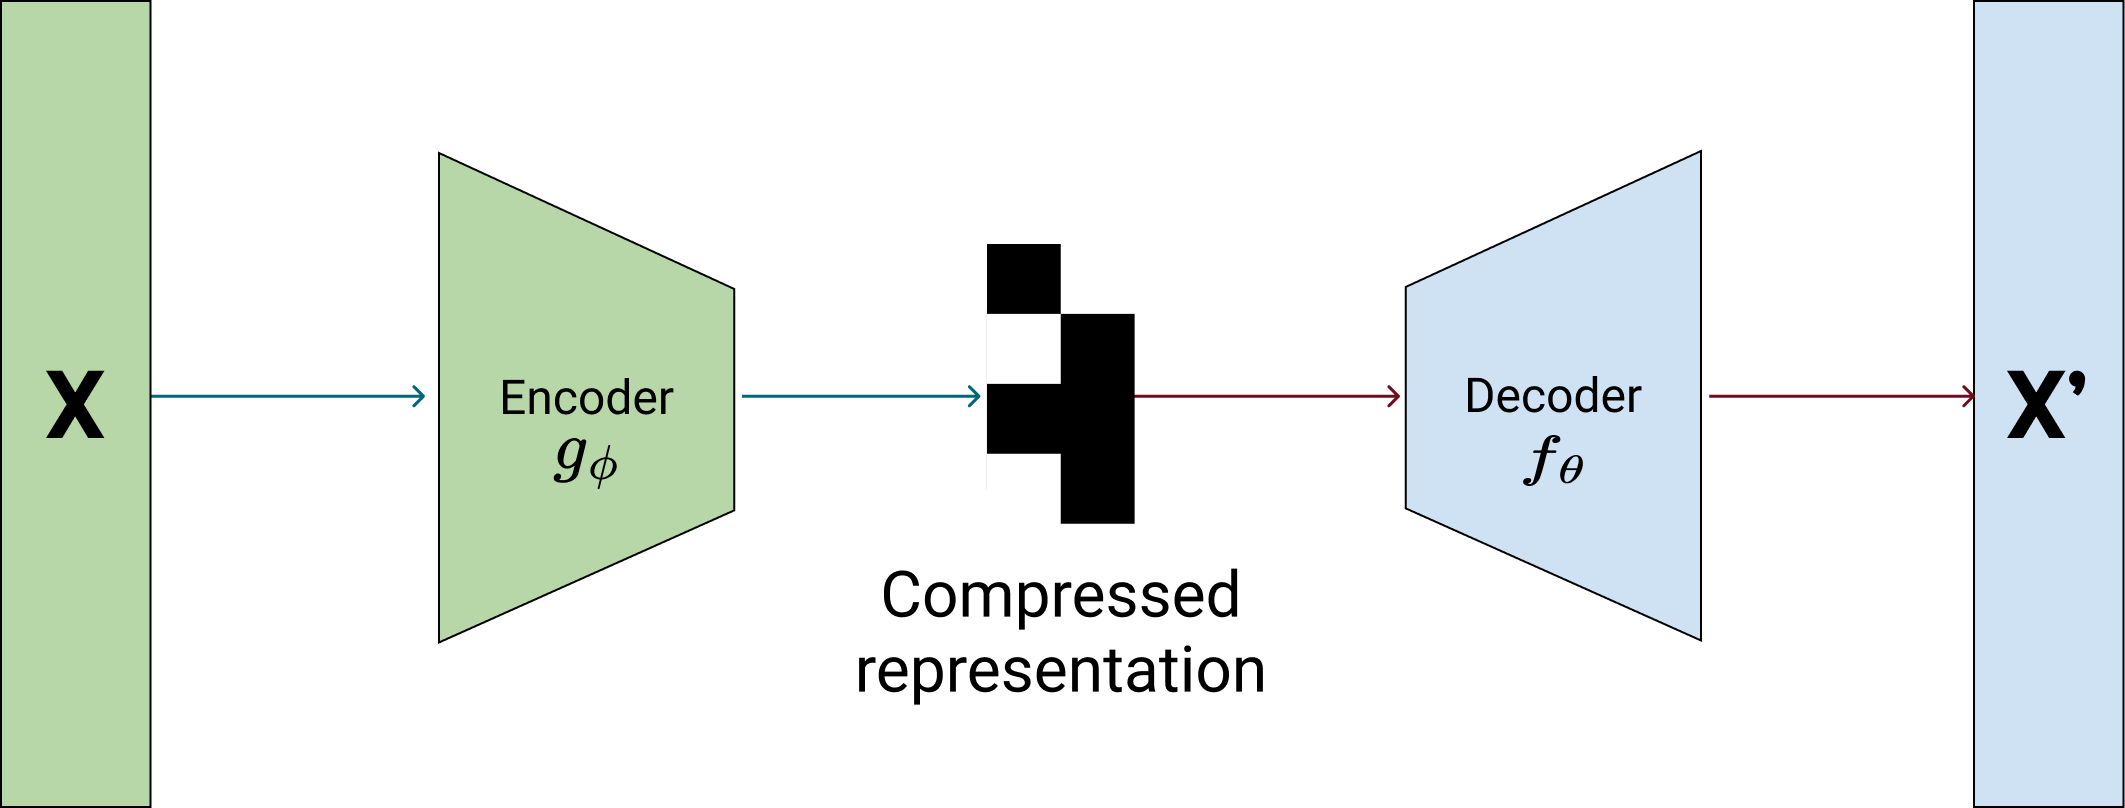

## Methodology <a name="background"></a>

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from skimage.metrics import mean_squared_error
import pandas as pd
import plotly.graph_objects as go
from sklearn.metrics.pairwise import cosine_similarity
import scipy.spatial.distance as distance
from sklearn.preprocessing import MinMaxScaler
from plotly.subplots import make_subplots

import statistics

### Description of the input dataset <a name="read"></a>
The method requires a dataset with two columns, specifically:

- **timestamp column** must contain the observation timestamp of each action or event. This column serves as a temporal reference and enables chronological ordering of the data instances.
- **values column** must contain the corresponding value of the variable measured at the given moment in time. This column captures the numeric information associated with each action or event. The nature of the variable may vary depending on the problem domain, ranging from numerical to categorical. In this blog post, we only deal with numerical cases.

In certain scenarios, the actions or events may span across two consecutive days, with their start times falling on the boundary of midnight. To ensure proper handling of such edge cases, a preprocessing step is necessary to split these instances into two separate rows. This division accurately represents the time sequence and prevents potential data inconsistencies or biases due to the spanning events.

In this example we analyzed *machine_temperature_system_failure* from [Numenta Anomaly Benchmark](https://github.com/numenta/NAB/blob/master/data/realKnownCause/machine_temperature_system_failure.csv).
The dataset comprises information gathered by a temperature sensor monitoring an component of a large industrial machine.

In [ ]:
import plotly.graph_objects as go
import pandas as pd

#Load dataset
df = pd.read_csv("https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/machine_temperature_system_failure.csv")

df = df[0:3000]

#anomalies labels
anomaly_points = [
        ["2013-12-10 06:25:00.000000","2013-12-12 05:35:00.000000"],
    ]

df['anomaly'] = 0

for start, end in anomaly_points:
    df.loc[((df['timestamp'] > start) & (df['timestamp'] < end)), 'anomaly'] = 1

# Define a list of colors, where 'green' is used to represent non-anomaly points and 'red' is used to represent anomaly points
colors = ['green' if a == 0 else 'red' for a in df['anomaly']]

# Define a new plot with 'timestamp' as the x-axis and 'value' as the y-axis.
fig = go.Figure()

# Add the non-anomaly points with green color
fig.add_trace(go.Scatter(
    x=df[df['anomaly'] == 0]['timestamp'],
    y=df[df['anomaly'] == 0]['value'],
    mode='markers',
    marker=dict(color='green', size=4),
    name='Normal'  # Legend label for good data points
))

# Add the anomaly points with red color
fig.add_trace(go.Scatter(
    x=df[df['anomaly'] == 1]['timestamp'],
    y=df[df['anomaly'] == 1]['value'],
    mode='markers',
    marker=dict(color='red', size=4),
    name='Shift anomaly'  # Legend label for anomaly data points
))

# Add a horizontal line representing the mean value
mean_value = df['value'].mean()
fig.add_shape(
    type='line',
    x0=df['timestamp'].min(),
    y0=mean_value,
    x1=df['timestamp'].max(),
    y1=mean_value,
    line=dict(color='black', dash='dash'),
    name='Mean Value'  # Legend label for the mean line
)

# Set the title and axis labels for the plot, and show the legend
fig.update_layout(
    title=dict(text='Hourly Values', x=0.5),
    xaxis_title='Timestamp',
    yaxis_title='Temperature Values',
    showlegend=True,
)

# Display the plot.
fig.show()


### Data transformation <a name="transform"></a>

Upon loading the dataset, it is divided into two parts: the training data, which comprises the user-selected standard data, and the unseen data, consisting of new data intended for visualization. Subsequently, the proposed method generates data sub-sequences of length $t$ from the dataset and transforming it into the action matrix, denoted as matrix $A$.

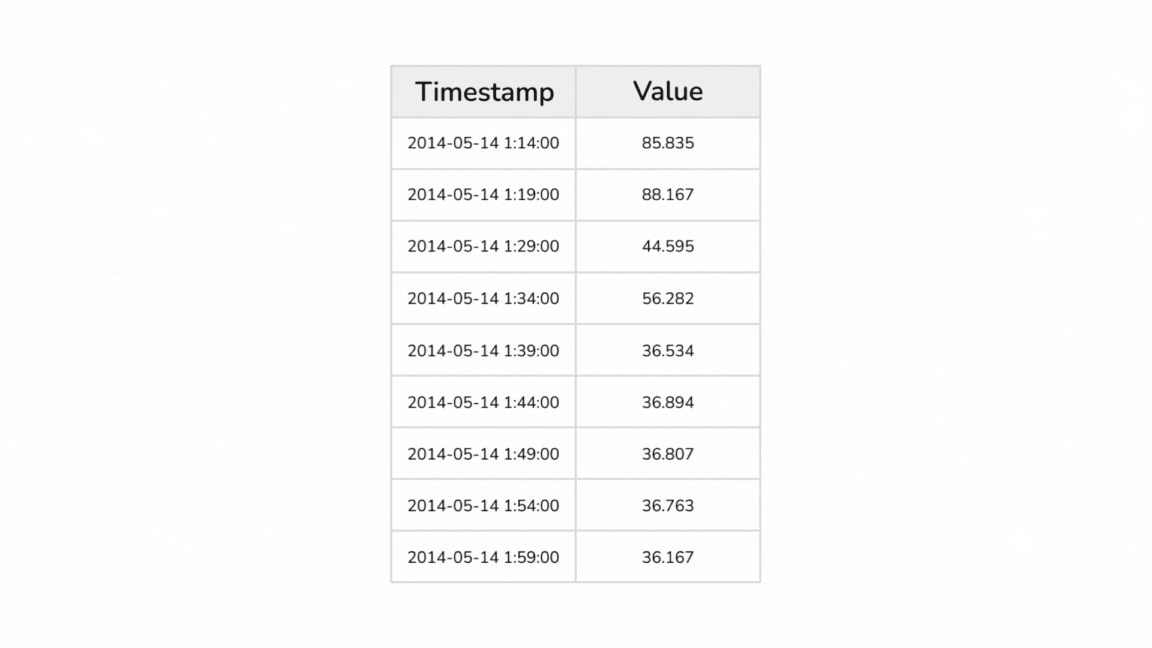

"t" represents a hyperparameter in the proposed algorithm that can be adjusted to observe how the visualization evolves. Here t is set to 20

In [ ]:
t = 20

In [ ]:
# Resetting the index of the DataFrame
df.reset_index()

# Extracting the nomral and unseen value column from the DataFrame and converting it to a NumPy array
train_set1 = np.array(df[0:1700]["value"]) # set representing the normality based on the user experience
test_set1 = np.array(df[1700:3000]["value"]) # set representing the new data to visualize

# Reshaping the train and test sets into a 2D array with 100 rows and 20 columns
train = np.reshape(train_set1[0:1700], (85, t))
test = np.reshape(test_set1[0:1300], (65, t))

### Autoencoder architecture <a name="arthictecture"></a>

Following this, each sub-sequences from the normal data subset is fed into the autoencoder, which is employed to capture the underlying concept of normality.

This model architecture takes a 1D input with shape `(1, t)`.
The input is passed through a 1D convolutional layer with 8 filters of size 4 and a ReLU activation function.
The resulting feature map is then downsampled using a max-pooling layer with a pool size of 2.
Next, the encoded representation is passed through an up-sampling layer, increasing the dimensionality of the data back to its original size.
The up-sampled feature map is then processed by another 1D convolutional layer with 8 filters of size 4 and ReLU activation function.
Finally, the reconstructed output is obtained by applying a 1D convolutional layer with 1 filter of size 3 and a sigmoid activation function.
Overall, this model follows an autoencoder architecture, aiming to compress the input data in the encoding layers and then reconstruct it in the decoding layers.

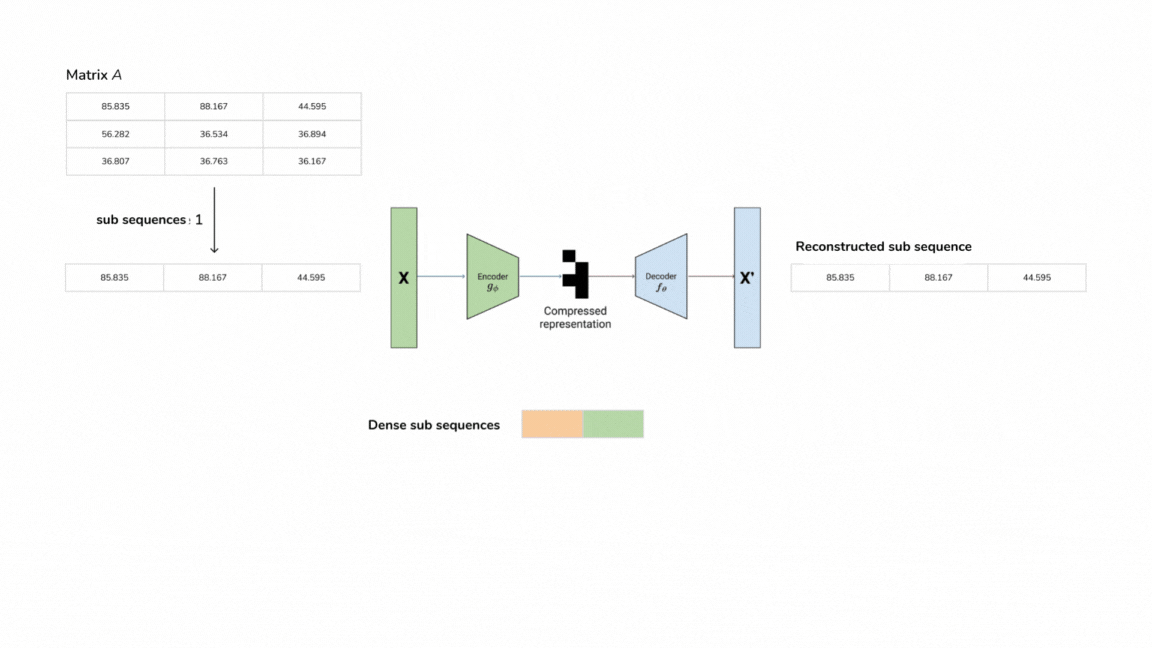

The resulting dense matrix is denoted as $A'$

In [ ]:
# Define the input layer
input = layers.Input(shape=(t, 1))

# Encoder layers
x = layers.Conv1D(8, 4, activation='relu', padding='same')(input)
encoder = layers.MaxPooling1D(2)(x)

# Decoder layers
x1 = layers.Conv1D(8, 4, activation='relu', padding='same')(encoder)
x1 = layers.UpSampling1D(2)(x1)
decoder = layers.Conv1D(1, 3, activation='sigmoid', padding='same')(x1)

# Create the autoencoder model
autoencoder = Model(input, decoder)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

def preprocess(array):
    # Normalize the array to values between 0 and 1
    array = (array - np.min(array)) / (np.max(array) - np.min(array)).astype("float32")
    # Reshape the array to match the input shape of the model
    array = np.reshape(array, (len(array), t, 1))
    return array

# Preprocess the train, validation, and test data
preprocess_train = preprocess(train)
preprocess_test = preprocess(test)

# Train the autoencoder model
history = autoencoder.fit(
    x=preprocess_train,
    y=preprocess_train,
    epochs=20,
    batch_size=32,
    shuffle=True,
    verbose=0
)

# Create an encoder model that takes the input and outputs the encoded representation
encoder_model = Model(inputs=input, outputs=encoder)

# Generate predictions using the autoencoder on the test data
predictions = autoencoder.predict(preprocess_test)

# Calculate mean squared error (MSE) and root mean squared error (RMSE) for evaluation purposes
mse = mean_squared_error(preprocess_test.squeeze(2), predictions.squeeze(2))
rmse = np.sqrt(mse)

# Encode the training, validation, and test data using the encoder model
X_train_encode = encoder_model.predict(preprocess_train)
X_test_encode = encoder_model.predict(preprocess_test)

### Profile similarity comparison <a name="comparison"></a>

Subsequently, the method performs the following functions:
- **Sub-sample generation**:  given $A'$, the algorithm generates sub-portions of the matrix of dimension $(t,l)$. It selects the first sub-sample $A'[0:l]$
- **Similarity scores matrix generation**: once a sub-sample is chosen, it is compared with all the others extracted by sliding one row at a time on $A'$.
Initially, $A'[0:l]$ is compared with *$A'[0:l]$*, representing a self-comparison for the first sub-sample. Then, the process proceeds by moving one row down, comparing $A'[0:l]$ with *$A'[1:l]$*, and generating similarity percentages for each comparison. This iterative process continues until $A'[0:l]$ is compared with all sub-samples from $A'$, resulting in a similarity vector containing the computed scores. This entire procedure is repeated for all the sub-samples that can be chosen from $A'$. As a result, the algorithm generates a matrix, denoted as *scores matrix*, where each row represents a similarity vector for a specific sub-sample.
- **Mean scores vector generation**: The subsequent step involves calculating the mean value for each row of the *scores matrix*. This process generates a vector referred to as the data normality reference. The resultant vector serves as a reference for normality, allowing the user to compare the trend of new unseen data visually.

Finally, the algorithm computes the mean and standard deviation of the **mean scores vector**. These two values make it possible to create a flexible thresholding method to detect an increase or decrease in data trends. The system considers 2*$\rho$ to set a visual reference for the expected behavior. If some values are out of this reference, the data differs effectively from the expected profile.

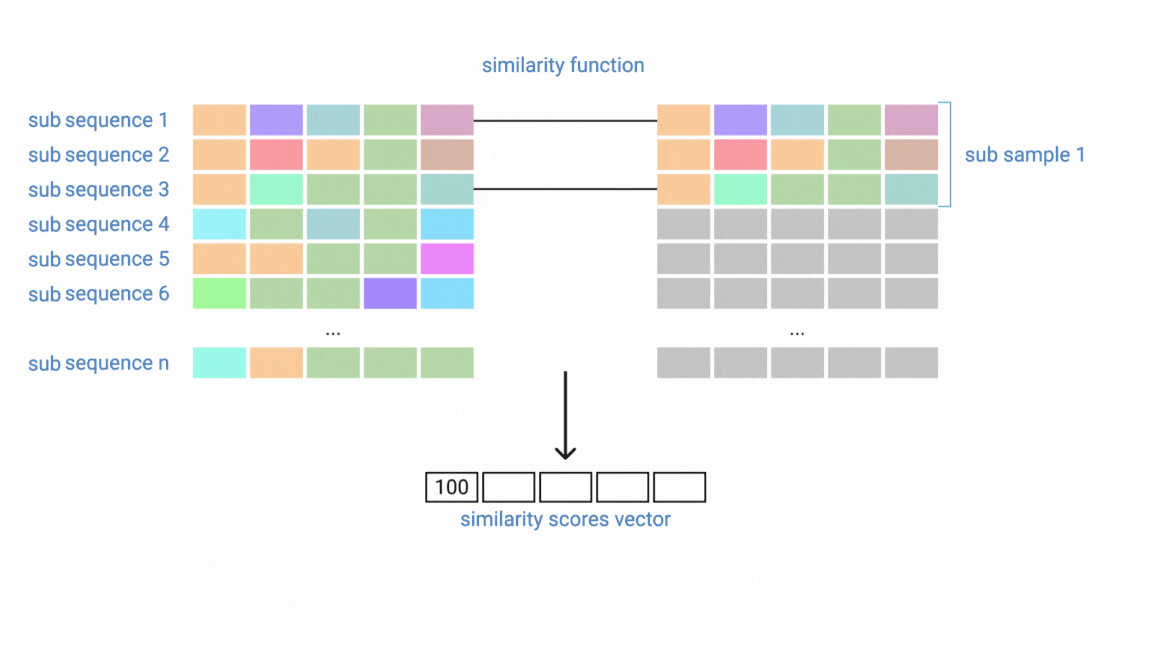

"l" represents the sub-sample dimension hyperparameter that can be adjusted to observe how the visualization evolves. Here l is set to 3

In [ ]:
l = 5

In [ ]:
# Compare subsections using cosine similarity
def computeSimilarity (t1, t2, t):
    from scipy import sparse
    t1= t1.reshape(t1.shape[0],t1.shape[1]*t1.shape[2])
    t2= t2.reshape(t2.shape[0],t2.shape[1]*t2.shape[2])
    similarities = cosine_similarity(t1, t2)
    return np.triu(similarities).mean()

# This function run the process described for the normal data
def computeNormalReference(train, t):
  normal_scores = []
  for i in range (0, len(train)-t):
    test = train[i:i+t]
    similarities = []
    for j in range (0, len(train)-t):
      perc = computeSimilarity(train[j:j+t], test, t)
      similarities.append(perc)
    normal_scores.append(statistics.mean(similarities))
  mean = np.array(normal_scores).mean()
  std = np.std(np.array(normal_scores))
  return [mean, std, normal_scores]


# Run the comparion of test data against the normal data reference
def fitModelShiftDetection (train, mean, std, test,l, train_scores ,train_ = False):
  test_scores = []
  for i in range (0, len(train)-len(test)):
    similarity = computeSimilarity(train[i:i+l], test, l)
    test_scores.append(similarity)
  return np.asarray(test_scores).mean()
mean, std, train_scores = computeNormalReference(X_train_encode, l)

test_scores = []
for i in range (0, len(X_test_encode)-l):
  scores = fitModelShiftDetection(X_train_encode, mean, std, X_test_encode[i:i+l],  l, train_scores)
  test_scores.append(scores)

The transformation operations depicted lead to the reduction of the initial matrix A of $l$ rows. To address this issue, we have implemented a solution that involves padding the similarity score vector, by sampling $l$ values from the uniform distribution of normal and unseen score vectors.

In [ ]:
# Calculate the mean and standard deviation of the train_scores
mean_train = np.mean(train_scores)
std_train = np.std(train_scores)

# Calculate the mean and standard deviation of the test_scores
mean_test = np.mean(test_scores)
std_test = np.std(test_scores)

# Create a list of l random numbers sampled from a uniform distribution within
# one standard deviation of the mean_train, and repeat it l times
pad_train = train_scores + [np.random.uniform(mean_train - std_train, mean_train + std_train, 1)] * l

# Create a list of l random numbers sampled from a uniform distribution within
# one standard deviation of the mean_test, and repeat it l times
pad_test = test_scores + [np.random.uniform(mean_test - std_test, mean_test + std_test, 1)] * l

After the method has processed the normal data to establish the concept of data normality, the unseen subset is fed into the autoencoder to obtain its latent representation. If any of the unseen samples deviate from the normal pattern, the autoencoder will face difficulties in reconstructing them, resulting in distinct representations compared to the normal ones. Subsequently, the same steps are applied to analyze and visualize this data, ultimately presenting it in the form of a scatter plot.

# Conclusion and results <a name="conclusion_and_results"></a>

In the chart below, the first graph's yellow points denote the user-selected "normal data," while the green points represent the newly introduced data. In the second graph, the original dataset remains unchanged without any transformation.
The red points reprents the data points affected by the shift anomaly, used as reference to compare the two chart in the same area.

Upon comparing the two charts, it becomes evident that our method significantly improves anomaly visualization compared to the conventional scatter plot. It effectively filters out normal data, focusing solely on peculiar behaviors and enhancing anomaly visibility in the relevant regions.


In [ ]:
def plotShiftDetectionPlot(train_scores, test_scores, df):
    train_scores = np.asarray(train_scores)
    test_scores = np.asarray(test_scores)

    y = list(train_scores) + list(test_scores)
    x = list(range(len(y)))

    c1 = colors = ['green' if a == 0 else 'red' for a in df['anomaly']]
    c2 = ['orange' for _ in range(len(train_scores))] + c1[len(train_scores):-1]

    y += [1, -1]
    scaler = MinMaxScaler()
    y = scaler.fit_transform(np.asarray(y).reshape(-1, 1))
    y = list(y)
    y = y[0:-2]

    mean = np.asarray(y[0:len(train_scores)]).mean()
    std = np.std(y[0:len(train_scores)])
    min_val = mean - 2 * std
    max_val = mean + 2 * std
    y = [data[0] for data in y]


    # Initialize figure with subplots
    fig = make_subplots(
        rows=2, cols=1, subplot_titles=("Our method", "Vanilla scatter"), shared_xaxes=True, shared_yaxes=False
    )

    fig.add_trace(go.Scatter(x=x, y=y, mode='markers', marker=dict(color=c2)), row=1, col=1)
    fig.add_shape(type="line", x0=0, x1=len(y)-1, y0=mean, y1=mean, line=dict(color='gray', width=1, dash='dash'), name="Mean", row=1, col=1)
    fig.add_shape(type="line", x0=0, x1=len(y)-1, y0=min_val, y1=min_val, line=dict(color='blue', width=1, dash='dash'), name="Min", row=1, col=1)
    fig.add_shape(type="line", x0=0, x1=len(y)-1, y0=max_val, y1=max_val, line=dict(color='blue', width=1, dash='dash'), name="Max", row=1, col=1)
    fig.update_xaxes(title="Timestep", row=1, col=1)
    fig.update_yaxes(title="Similarity score", row=1, col=1)


    # Add an empty subplot to the second column
    yy = df['value']
    fig.add_trace(go.Scatter(x=x, y=yy, mode='markers', marker=dict(color=c1), showlegend= True), row=2, col=1)
    fig.update_xaxes(title="Timestep", row=2, col=1)
    fig.update_yaxes(title="Temeperature", row=2, col=1,side='left')


    # Add the second scatter plot to the second column
    fig.update_layout(title="Our method vs. Vanilla Scatter", showlegend=False, xaxis2=dict(showgrid=True, zeroline=True, showticklabels=True), yaxis2=dict(showgrid=True, zeroline=True, showticklabels=True))
    fig.show()

plotShiftDetectionPlot(np.repeat(pad_train, t) , np.repeat(pad_test, t), df)


In conclusion, the proposed methodology reduces the emphasis on normality and accentuates the detection of anomalies, enabling users to concentrate solely on relevant information.

Moreover, this method challenges the conventional notion of regular data, as it suggests the presence of certain data points within the normal range that may appear peculiar or unusual. It offers an insightful analysis by striking a balance between highlighting anomalies and reducing the visibility of normal data variations.

# References <a name="references"></a>

1. Yildirim, Ozal, Ru San Tan, and U. Rajendra Acharya. **"An efficient compression of ECG signals using deep convolutional autoencoders.**" Cognitive Systems Research 52 (2018): 198-211.
2. La Rosa, Biagio, et al. **"State of the art of visual analytics for explainable deep learning."** Computer Graphics Forum. Vol. 42. No. 1. 2023.
3. Liu, Jiayi, et al. **"Anomaly and change point detection for time series with concept drift."** World Wide Web (2023): 1-24.